<a href="https://colab.research.google.com/github/TakuInada/umcuEpi_longterm_ieeg_respect_bids/blob/master/RemoveArti_ZapLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pyedflib
!pip install pyriemann
!pip install git+https://github.com/nbara/python-meegkit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734979 sha256=747169beda584dae78111280cf64ffec3f479922c6c1627f77d9d2b0e5e4b8b4
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyedflib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 3.6 MB/s eta 0:00:00
  Cloning https://github.com/nbara/python-meegkit.git to /tmp/pip-req-build-ojq3a05f
  Running command git clone --filter=blob:none --quiet https://github.com/nbara/python-meegkit.git /tmp/pip-req-build-ojq3a05f
  Resolved https://github.com/nbara/python-meegkit.git to commit e44c4bb6ce174096efb80365717ff112af12486c
  Installing build dependencies ... done
  Getting requirements to build wheel ... d

In [5]:
# import the library
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

from meegkit import dss
from meegkit.utils import unfold
from meegkit.utils.denoise import demean

import pyedflib

In [8]:
#!pip download https://dataverse.tdl.org/api/access/datafile/37645
file = pyedflib.EdfReader("EEG_Cat_Study4_Resting_S1.bdf")
n = file.signals_in_file # 73
signal_labels = file.getSignalLabels() # len(signal_labels): 73

sigbufs = np.zeros((n, file.getNSamples()[0])) # sigbufs.shape: (73, 130560)
for i in np.arange(n):
    sigbufs[i, :] = file.readSignal(i)

#header = file.getSignalHeaders()
sfreq = file.getSampleFrequencies()[0] # sample frequency
X = sigbufs[:67, :20000]
X = demean(X.T) # centering the data

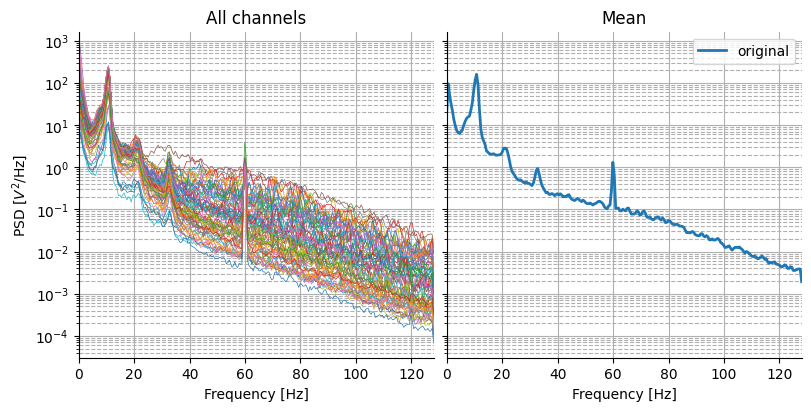

In [9]:
freq, Pxx = signal.welch(unfold(X), sfreq, nperseg=500, axis=0,
                         return_onesided=True)
fig, ax = plt.subplots(1, 2, figsize=(8, 4),
                       sharey=True, constrained_layout=True)
ax[0].semilogy(freq, Pxx, lw=.5)
ax[0].set_title('All channels')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel(r'PSD [$V^2$/Hz]')
ax[0].grid(True, which="major")
ax[0].grid(True, which="minor", linestyle='dashed')
ax[0].set_xlim(freq[0], freq[-1])

ax[1].semilogy(freq, Pxx.mean(1), lw=2, label="original")
ax[1].set_title('Mean')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which="major")
ax[1].grid(True, which="minor", linestyle='dashed')
ax[1].set_xlim(freq[0], freq[-1])
ax[1].legend()
plt.show()

Power of components removed by DSS: 0.00


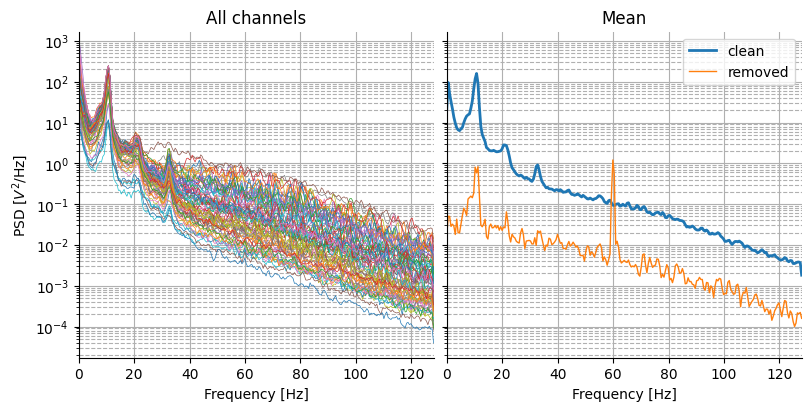

In [10]:
fline = 60 # line frequency

# Apply dss_line (ZapLine)
out, _ = dss.dss_line(X, fline, sfreq, nremove=3, nfft=1024)

freq, Pxx_out = signal.welch(unfold(out), sfreq, nperseg=500, axis=0,
                             return_onesided=True)

fig, ax = plt.subplots(1, 2, figsize=(8, 4),
                       sharey=True, constrained_layout=True)
ax[0].semilogy(freq, Pxx_out, lw=.5)
ax[0].set_title('All channels')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel(r'PSD [$V^2$/Hz]')
ax[0].grid(True, which="major")
ax[0].grid(True, which="minor", linestyle='dashed')
ax[0].set_xlim(freq[0], freq[-1])

ax[1].semilogy(freq, Pxx_out.mean(1), lw=2, label="clean")
ax[1].semilogy(freq, np.abs(Pxx - Pxx_out).mean(1), lw=1,
               label="removed")
ax[1].set_title('Mean')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which="major")
ax[1].grid(True, which="minor", linestyle='dashed')
ax[1].set_xlim(freq[0], freq[-1])
ax[1].legend()
plt.show()